In [1]:
# Forward & Backward SDE trajectories + PDFs at t=0, t=t_mid, t=T for OU process
# Uses matplotlib only (no seaborn), one chart per figure.
import numpy as np
import matplotlib.pyplot as plt



In [8]:
# -----------------
# OU parameters 
# -----------------
beta = 1.0
sigma = 1.5
mu0 = 2.5
s0 = 0.6
T = 30.0
t_mid = 1.5

rng = np.random.default_rng(7)

def m_t(t): return np.exp(-beta * t) * mu0
def v_t(t): 
    return (np.exp(-2*beta*t) * s0**2) + (sigma**2/(2*beta)) * (1.0 - np.exp(-2*beta*t))

def gaussian_pdf(x, mean, var):
    return (1.0/np.sqrt(2*np.pi*var)) * np.exp(-0.5*((x-mean)**2)/var)



In [9]:
# -----------------
# Forward SDE simulation
# -----------------
dt = 1e-3
steps = int(T/dt)
N = 2000          # particles for density
K = 25            # trajectories to draw

# initial samples from p0
x = rng.normal(loc=mu0, scale=s0, size=N)
x_traj = x[:K].copy()

# storage for a few snapshots
snap_0 = x.copy()
snap_mid = None
snap_T = None

# simulate forward
ts = [0.0]
traj = [x_traj.copy()]
t=0.0
for i in range(1, steps+1):
    dW = rng.normal(0.0, np.sqrt(dt), size=N)
    x = x + (-beta * x) * dt + sigma * dW
    if i % int(steps/K) == 0:  # update the K lines with the corresponding indices
        x_traj = x[:K].copy()
        traj.append(x_traj.copy())
        ts.append(i*dt)
    if snap_mid is None and t < t_mid <= t+dt:
        snap_mid = x.copy()
    t += dt
snap_T = x.copy()



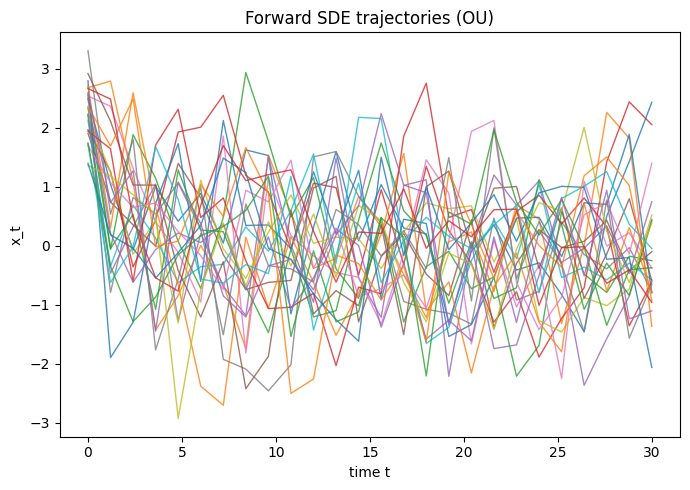

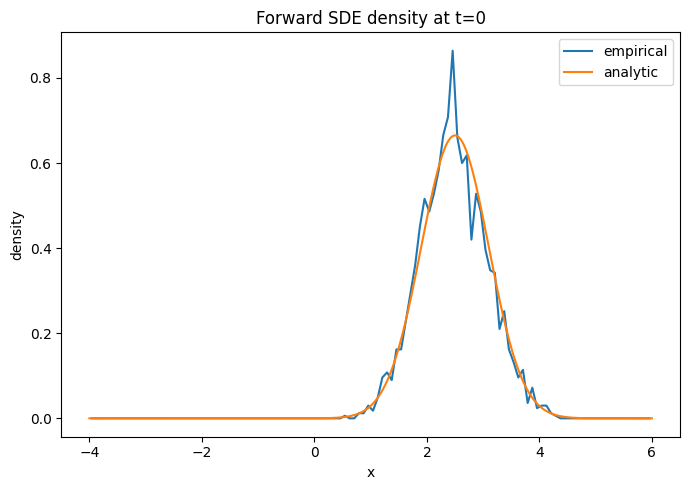

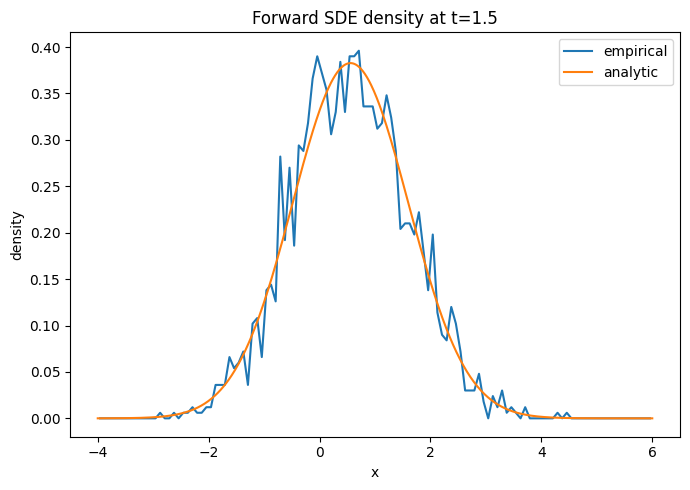

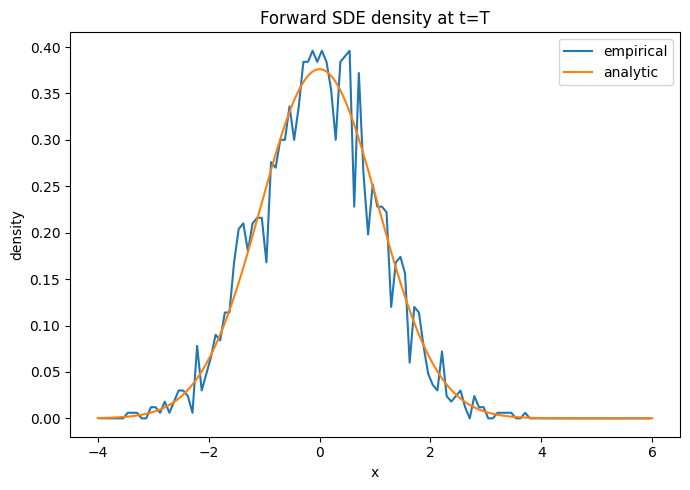

In [10]:
# Draw forward trajectories (K lines)
plt.figure(figsize=(7,5))
for j in range(K):
    ys = [tr[j] for tr in traj]
    plt.plot(ts, ys, linewidth=1, alpha=0.8)
plt.title("Forward SDE trajectories (OU)")
plt.xlabel("time t")
plt.ylabel("x_t")
plt.tight_layout()
plt.show()

# PDFs for forward at t=0, t=t_mid, t=T
xs = np.linspace(-4, 6, 800)

def plot_pdf_from_samples(samples, title):
    # histogram density vs analytic Gaussian
    h, edges = np.histogram(samples, bins=120, range=(-4,6), density=True)
    centers = 0.5*(edges[1:]+edges[:-1])
    plt.figure(figsize=(7,5))
    plt.plot(centers, h, label="empirical")
    # analytic line
    if "t=0" in title:
        mt, vt = m_t(0.0), v_t(0.0)
    elif "t=T" in title:
        mt, vt = m_t(T), v_t(T)
    else:  # t=t_mid
        mt, vt = m_t(t_mid), v_t(t_mid)
    plt.plot(xs, gaussian_pdf(xs, mt, vt), label="analytic")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("density")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pdf_from_samples(snap_0,  f"Forward SDE density at t=0")
plot_pdf_from_samples(snap_mid, f"Forward SDE density at t={t_mid}")
plot_pdf_from_samples(snap_T,   f"Forward SDE density at t=T")



In [ ]:
# -----------------
# Backward (Reverse) SDE trajectories (from p_T to p_0)
# -----------------
dt_b = -dt
steps_b = steps

# start from p_T
x = rng.normal(loc=m_t(T), scale=np.sqrt(v_t(T)), size=N)
x_traj = x[:K].copy()

snap_T_b = x.copy()
snap_mid_b = None
snap_0_b = None

ts_b = [T]
traj_b = [x_traj.copy()]
t=T
for i in range(1, steps_b+1):
    mt = m_t(t); vt = v_t(t)
    drift = (-beta * x + (sigma**2) * (x - mt)/vt)
    dWbar = rng.normal(0.0, np.sqrt(abs(dt_b)), size=N)
    x = x + drift * dt_b + sigma * dWbar
    if i % int(steps_b/K) == 0:
        x_traj = x[:K].copy()
        traj_b.append(x_traj.copy())
        ts_b.append(T - i*abs(dt_b))
    if snap_mid_b is None and t-dt <= t_mid < t:
        snap_mid_b = x.copy()
    t += dt_b
snap_0_b = x.copy()

plt.figure(figsize=(7,5))
for j in range(K):
    ys = [tr[j] for tr in traj_b]
    plt.plot(ts_b, ys, linewidth=1, alpha=0.8)
plt.title("Reverse SDE trajectories (OU)")
plt.xlabel("time t")
plt.ylabel("x_t")
plt.tight_layout()
plt.savefig("/mnt/data/reverse_trajectories.png", dpi=160)
plt.show()

plot_pdf_from_samples(snap_T_b,  f"Reverse SDE density at t=T",   "/mnt/data/reverse_pdf_tT.png")
plot_pdf_from_samples(snap_mid_b, f"Reverse SDE density at t={t_mid}", "/mnt/data/reverse_pdf_tmid.png")
plot_pdf_from_samples(snap_0_b,   f"Reverse SDE density at t=0",  "/mnt/data/reverse_pdf_t0.png")

print("Saved:",
      "/mnt/data/forward_trajectories.png",
      "/mnt/data/forward_pdf_t0.png",
      "/mnt/data/forward_pdf_tmid.png",
      "/mnt/data/forward_pdf_tT.png",
      "/mnt/data/reverse_trajectories.png",
      "/mnt/data/reverse_pdf_tT.png",
      "/mnt/data/reverse_pdf_tmid.png",
      "/mnt/data/reverse_pdf_t0.png")
